In [139]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
import scipy.stats as sts
import copy
from decimal import *
from sklearn.datasets import load_iris
from scipy.optimize import minimize
from scipy.special import expit
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (linear_kernel, rbf_kernel, polynomial_kernel, sigmoid_kernel, laplacian_kernel)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y
import data_gen
import time
dataDir = "./Data/"

In [147]:
def plotData(x, t):
    # Plot the data
    classA = x[t == 1]
    classB = x[t == 0]
    plt.xlabel('X Axis (No units)')
    plt.ylabel('Y Axis (No units)')
    plt.plot(classA[:,0], classA[:,1], 'bo')
    plt.plot(classB[:,0], classB[:,1], 'ro')
    plt.legend(["Class A","Class B"])
    plt.show()

In [144]:
def normalizeLabels(X, t):
    result_X = []
    result_t = []
    classes = np.unique(t)
    class0 = classes[0]
    class1 = classes[1]
    for i in range(len(t)):
        if (t[i] == class0 or t[i] == class1):
            if (t[i] == class0):
                result_t.append(0)
            else:
                result_t.append(1)
            result_X.append(X[i])
    return np.array(result_X), np.array(result_t)

In [258]:
# x_tr: feature vectors of training dataset
# t_tr: labels of training dataset
# x_tst: grid of feature vectors for drawing classes' areas
# t_tst: results of classification of the grid
# x_sv: support vectors
def plotClassification(x_tr, t_tr, x_tst, t_tst, x_sv):   
    #First we plot the training points
    classA_tr = x_tr[t_tr == 1]
    classB_tr = x_tr[t_tr == 0]
    
    plt.clf()
    plt.plot(classA_tr[:,0], classA_tr[:,1], 'bo')
    plt.plot(classB_tr[:,0], classB_tr[:,1], 'ro')
      
    #Then, we plot the support vectors
    plt.plot(x_sv[:,0], x_sv[:,1] , 'go', markersize = 15, mfc = "None") 
    
    plt.legend(["Class A","Class B", "Support Vectors"])
    
    #Finally, we plot the test results
    classA_tst = x_tst[t_tst == 1]
    classB_tst = x_tst[t_tst == 0]
    
    plt.xlabel('X Axis (No units)')
    plt.ylabel('Y Axis (No units)')

    plt.plot(classA_tst[:,0], classA_tst[:,1], 'bs', alpha=0.05)
    plt.plot(classB_tst[:,0], classB_tst[:,1], 'rs', alpha=0.05)
    #plt.savefig('toy_example_RVM_C.pdf')
    plt.show()

In [121]:
def radialKernel(X1, X2, params):
    return laplacian_kernel(X1, X2, params[0])

In [105]:
def linearKernel(X1, X2, params = None):
    return linear_kernel(X1, X2)

In [107]:
def polynomialKernel(X1, X2, params):
    degree = params[0]
    return polynomial_kernel(X1, X2, degree)

In [127]:
def sigmoidKernel(X1, X2, params = None):
    return sigmoid_kernel(X1, X2)

In [111]:
def gaussianKernel(X1, X2, params):
    gamma = params[0]
    return rbf_kernel(X1, X2, gamma)

In [ ]:
# Ripley toy example
X_tr, t_tr = genRipley()
X_tr, t_tr = normalizeLabels(X_tr, t_tr)
h = 70
x_0_min = np.min(X_tr[:,0])
x_0_max = np.max(X_tr[:,0])
x_1_min = np.min(X_tr[:,1])
x_1_max = np.max(X_tr[:,1])
xx0, xx1 = np.meshgrid(np.linspace(x_0_min, x_0_max, num=h), np.linspace(x_1_min, x_1_max, num=h))
X_tst = np.vstack((xx0.reshape(1,-1),xx1.reshape(1,-1))).T
#plotData(X_tr, t_tr)
kernel = gaussianKernel
kernelParams = [0.5]
X_res, alphas_res, w_res, Phi_res = SSBL_RVM_C(X_tr, t_tr, kernel, kernelParams, update_fn = "DD", max_iter_num = 1000, \
                                               opt_max_iter = 300)
prediction = predict(X_tst, X_res, w_res, kernel, kernelParams)
plotClassification(X_tr, t_tr, X_tst, prediction, X_res)

converged


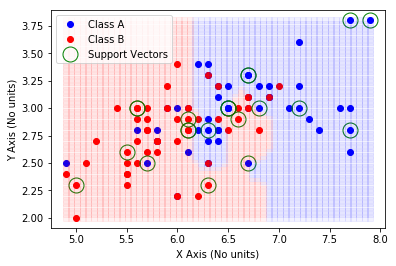

In [264]:
# Iris toy example
iris = load_iris()
X = []
t = []

for i in range(len(iris.data)):
    if iris.target[i] == 1 or iris.target[i] == 2:
        X.append(iris.data[i][:-2])
        t.append((iris.target[i]-1)) # TODO: Identify unique labels, change to 0/1-format
X = np.array(X)
t = np.array(t)

h = 55
x_0_min = np.min(X[:,0])
x_0_max = np.max(X[:,0])
x_1_min = np.min(X[:,1])
x_1_max = np.max(X[:,1])
xx0, xx1 = np.meshgrid(np.linspace(x_0_min, x_0_max, num=h),
                         np.linspace(x_1_min, x_1_max, num=h))
X_tst = np.vstack((xx0.reshape(1,-1),xx1.reshape(1,-1))).T

kernel = radialKernel
kernelParams = [7.5]
X_res, alphas_res, w_res, Phi_res = SSBL_RVM_C(X, t, kernel, kernelParams, update_fn = "DD", max_iter_num = 1000, opt_max_iter = 100)
prediction = predict(X_tst, X_res, w_res, kernel, kernelParams)
plotClassification(X, t, X_tst, prediction, X_res)

In [60]:
def fetchDataset(dataset):
    return data_gen.genData(dataset)

In [266]:
# X: training feature vectors
# t: training labels
# kernel: function of the form "kernel(X1, X2, kernel_params)"
# kern_params: params for the passed kernel function
# returns: 
def SSBL_RVM_C(X, t, kernel, kernelParams, update_fn = "DD", max_iter_num = 1000, opt_max_iter = 100, tolerance = 1e-5,
          alpha_threshold = 1e6):

    N = len(t)
    Phi = kernel(X, X, kernelParams) #rbf_kernel(X, X, kern_param)
    Phi = np.append(Phi, np.ones((N, 1)), axis = 1)
    Phi_t = Phi.T
    opt_options = { 'maxiter': opt_max_iter }
    biasFlag = True
    numLessTol = 0
    w_mode = np.zeros(N+1)

    # Initialize the variables
    alphas = np.full(N+1, float("inf"))
    firstPhiCol = Phi[:,0]
    norm = np.sum(firstPhiCol*firstPhiCol)
    norm_t = np.sum(firstPhiCol*t)
    # Calculate var[t], sigma^2
    t_mean = np.mean(t)
    sigma_sq = 0.1*np.sum(np.fabs(t-t_mean))/(N-1)
    alphas[0] = (norm)/((norm_t/norm)-sigma_sq)

    basisVars = np.full(N+1, False)
    basisVars[0] = True
    basisPhi = Phi[:,basisVars]

    order = np.arange(N+1)
    B = np.zeros((N,N))
    B_inv = np.zeros((N,N))
    t_y = np.zeros(N)
    
    for iterNum in range(max_iter_num):
        basisChanged = False
        alphasDiff = 0
        #np.random.shuffle(order)
        for ind in order:
            basisAlphas = alphas[basisVars]
            basisPhi = Phi[:,basisVars]
            w0 = w_mode[basisVars]
            #try
            #    opt_res = minimize(fun=getLogPosterior, x0=np.zeros(len(basisAlphas)), hess=getHessian, method='Newton-CG', \
            #               args=(basisAlphas, basisPhi, basisPhi.T, t), jac=True, options=opt_options)
            #except:
            retryNum = 10
            for i in range(1,retryNum):
                try:
                    opt_res = minimize(fun=getLogPosterior, x0=w0, hess=getHessian, method='Newton-CG', \
                        args=(basisAlphas, basisPhi, basisPhi.T, t), jac=True, options={ 'maxiter': opt_max_iter*i })
                except:
                    print("not converged")
                    w0 = np.zeros(len(basisAlphas))
                if i == retryNum-1:
                    continue
            
            counter = 0
            for i in range(N+1):
                if (not basisVars[i]):
                    w_mode[i] = 0
                else:
                    w_mode[i] = opt_res.x[counter]
                    counter += 1
            
            Sigma_inv = getHessian(w_mode, alphas, Phi, Phi_t, t)
            Sigma_basis_inv = Sigma_inv[:,basisVars]
            Sigma_basis_inv = Sigma_basis_inv[basisVars,:]
            Sigma_basis = np.linalg.inv(Sigma_basis_inv)
            
            phi_w = np.dot(Phi, w_mode)
            y = expit(phi_w)
            # Compute B, B^{-1}
            for i in range(N):
                t_y[i] = t[i]-y[i]
                B[i][i] = y[i]*(1-y[i])
                if (B[i][i] == 0):
                    B_inv[i][i] = float("inf")
                else:
                    B_inv[i][i] = 1/B[i][i]
            
            phi_j = Phi[:,ind]
            phi_B = np.dot(phi_j.T, B)
            t_hat = phi_w + np.dot(B_inv,t_y)
            long_product = np.dot(phi_B, basisPhi).dot(Sigma_basis).dot(basisPhi.T).dot(B)
            S_j = np.dot(phi_B, phi_j) - np.dot(long_product, phi_j)
            Q_j = np.dot(phi_B, t_hat) - np.dot(long_product, t_hat)
            s_j = None
            q_j = None
            if (alphas[ind] > alpha_threshold):
                s_j = S_j
                q_j = Q_j
            else:
                s_j = (alphas[ind]*S_j)/(alphas[ind]-S_j)
                q_j = (alphas[ind]*Q_j)/(alphas[ind]-S_j)
                
            if (q_j*q_j > s_j+tolerance):
                if (alphas[ind] > alpha_threshold):
                    basisVars[ind] = True
                    basisChanged = True
                alphaPrev = alphas[ind]
                alphas[ind] = (s_j*s_j)/(q_j*q_j - s_j)
                alphasDiff += np.fabs(alphas[ind]-alphaPrev)
            else:
                if (alphas[ind] < alpha_threshold):
                    basisVars[ind] = False
                    basisChanged = True
                alphas[ind] = float("inf")
            
        if ((not basisChanged) and alphasDiff < tolerance):
            print("converged")
            break
    
    alphas_res = alphas[basisVars]
    w_res = w_mode[basisVars]
    Phi_res = Phi[:,basisVars]
    X_res = X[basisVars[:-1],:]
    
    # X_res: features of the support vectors
    # alphas_res: support vectors alphas
    # w_res: optimal parameters' values
    # Phi_res: Phi's of the support vectors
    return X_res, alphas_res, w_res, Phi_res

In [69]:
# This function filters out infinite alpha values and the columns of the design
# matrix that correspond to them
def filterOutInf(alphaVec,designMatrix,threshHold):
    nonInfIdx = np.where(alphaVec < threshHold)[0]
    filteredAlphaVec = alphaVec[nonInfIdx]
    filteredDesignMatrix = designMatrix[:,nonInfIdx]
    return filteredAlphaVec, filteredDesignMatrix

def sigmoidFn(y):
    return 1/(1+np.exp(-y))

def getqiAndsi(OGPhi,Phi,Phi_t, alphaVec,t,w,Sigma,threshold,basisInds,index):
    phiI = OGPhi[:,index].reshape((-1,1))
    phiI_t =phiI.T
    alphaI = alphaVec[index]
    y = np.array([np.dot(w.T,xn[basisInds]) for xn in OGPhi]).reshape((-1,1))
    t = t.reshape((-1,1))
    betas = np.array([sigmoidFn(yn)*(1-sigmoidFn(yn)) for yn in y]).flatten()
    B = np.diag(betas)
    if B.ndim == 1:
        B = B.reshape((-1,1))
    tEst = np.dot(Phi,w) + np.linalg.inv(B).dot((np.subtract(t,y)))

    Qi = phiI_t.dot(B).dot(tEst)
    Qi -= phiI_t.dot(B).dot(Phi).dot(Sigma).dot(Phi_t).dot(B).dot(tEst)

    Si = phiI_t.dot(B).dot(phiI)
    Si -= phiI_t.dot(B).dot(Phi).dot(Sigma).dot(Phi_t).dot(B).dot(phiI)

    if alphaI >= threshold:
        qi = Qi
        si = Si
    else:
        qi = alphaI*Qi/(alphaI-Si)
        si = alphaI*Si/(alphaI-Si)

    return qi, si

def getC(alphaVec,designMatrix,designMatrix_t,postMean):
    y = expit(np.dot(designMatrix, postMean))
    B = np.diag(y * (1 - y))
    A = np.diag(alphaVec)
    return B + np.dot(np.dot(designMatrix,A),designMatrix_t)
    
def updateAlphaValue(designMatrix,alphaVec,postMean,t,postCov,threshHold, index):
    C = getC(alphaVec,designMatrix,postMean)
    qi, si = getqiAndsi(designMatrix, alphaVec, C, t,postCov, threshHold,index)
    if qi**2 > si:
        return si**2/(qi**2-si)
    else:
        return math.inf


In [112]:
# X: training feature vectors
# t: training labels
# kernel: function of the form "kernel(X1, X2, kernel_params)"
# kern_params: params for the passed kernel function
# returns: 
def RVM_C(X, t, kernel, kernelParams, update_fn = "DD", max_iter_num = 1000, opt_max_iter = 100, tolerance = 1e-7, alpha_threshold = 1e7):

    # Gamma prior variables:
    a = 0
    b = 0
    c = 0
    d = 0 # These are all set to 0 since we, just like Tipping, assume uniform priors for the hyperparams
    
    N = len(t)
    Phi = kernel(X, X, kernelParams) #rbf_kernel(X, X, kern_param)
    Phi = np.append(Phi, np.ones((N, 1)), axis = 1)
    Phi_t = Phi.T
    opt_options = { 'maxiter': opt_max_iter }
    biasFlag = True
    numLessTol = 0

    numRelevant = N+1
    alphas = np.full(numRelevant, 1e-6)
    w_mode = np.zeros(numRelevant)

    alphas_res = None
    Phi_res = None
    w_res = None
    X_res = copy.deepcopy(X)

    for iterNum in range(max_iter_num):
        opt_res = minimize(fun=getLogPosterior, x0=w_mode, hess=getHessian, method='Newton-CG', \
                           args=(alphas, Phi, Phi_t, t), jac=True, options=opt_options)

        w_mode = opt_res.x
        Sigma = np.linalg.inv(getHessian(w_mode, alphas, Phi, Phi_t, t))

        # Prune basis functions

        basisInds = []
        sumDiff = 0
        for i in range(numRelevant):
            alpha_prev = alphas[i]
            
            if update_fn == "DD":
                alphas[i] = (1 - Sigma[i][i]*alpha_prev)/(w_mode[i]*w_mode[i])
            elif update_fn == "EM":
                weightEst = Sigma[i,i] + w_mode[i]**2
                alphas[i] = (1+2*a)/(weightEst+2*b)
                
            if (alphas[i] < alpha_threshold):
                basisInds.append(i)
                sumDiff += np.fabs(alphas[i]-alpha_prev)

        if (sumDiff < tolerance):
            numLessTol += 1
        if (numLessTol > 3 or iterNum == max_iter_num-1):
            # Save results
            
            numRelevant = len(basisInds)

            alphas_res = np.zeros(numRelevant)
            Phi_res = np.zeros((N, numRelevant))
            w_res = np.zeros(numRelevant)
            X_new = np.zeros((numRelevant - (1 if biasFlag else 0), len(X[0])))
            # a if condition else b

            for i in range(numRelevant):
                alphas_res[i] = alphas[basisInds[i]]
                w_res[i] = w_mode[basisInds[i]]
                for j in range(N):
                    Phi_res[j][i] = Phi[j][basisInds[i]]
                if (basisInds[i] != len(X_res) and i != len(X_new)):
                    for j in range(len(X[0])):
                        X_new[i][j] = X_res[basisInds[i]][j]

            X_res = X_new

            break

        if (len(basisInds) == 0):
            basisInds.append(0)
            # First iteration
            if (biasFlag):
                basisInds.append(len(alphas)-1)

        if (biasFlag):
            if not (alphas[-1] < alpha_threshold):
                biasFlag = False

        numRelevant = len(basisInds)

        alphas_new = np.zeros(numRelevant)
        Phi_new = np.zeros((N, numRelevant))
        w_mode_new = np.zeros(numRelevant)
        X_new = np.zeros((numRelevant - (1 if biasFlag else 0), len(X[0])))

        for i in range(numRelevant):
            alphas_new[i] = alphas[basisInds[i]]
            w_mode_new[i] = w_mode[basisInds[i]]
            for j in range(N):
                Phi_new[j][i] = Phi[j][basisInds[i]]
            if (basisInds[i] != len(X_res) and i != len(X_new)):
                for j in range(len(X[0])):
                    X_new[i][j] = X_res[basisInds[i]][j]

        alphas = alphas_new
        w_mode = w_mode_new
        Phi = Phi_new
        Phi_t = Phi.T
        X_res = X_new
        
    # X_res: features of the support vectors
    # alphas_res: support vectors alphas
    # w_res: optimal parameters' values
    # Phi_res: Phi's of the support vectors
    return X_res, alphas_res, w_res, Phi_res

def sparse_RVM_C(X, t, kernel, kernelParams, update_fn = "DD", max_iter_num = 10000, opt_max_iter = 100, tolerance = 1e-7,
                 alpha_threshold = 1e5):

    N = len(t)
    Phi = kernel(X, X, kernelParams)
    Phi = np.append(Phi, np.ones((N, 1)), axis = 1)
    Phi_t = Phi.T
    opt_options = { 'maxiter': opt_max_iter }
    biasFlag = True
    numLessTol = 0

    numRelevant = 1
    alphas = np.full(N+1, float('inf'))
    alphas[0] = 1e-6

    alphas_res = None
    Phi_res = None
    w_res = None
    X_res = copy.deepcopy(X)
    usedPhi = Phi[:,0].reshape((-1,1))
    basisInds =[0]
    w_mode = np.zeros(len(alphas[basisInds]))
    printStuff = False

    for iterNum in range(max_iter_num):
        
        if printStuff:
            print("New iteration")
            print("Used Phi:")
            print(usedPhi.shape)
            print("w_mode:")
            print(w_mode.shape)
            print("alphas:")
            print(alphas.shape)
            print("basisInds:")
            print(basisInds)
        w_mode = np.zeros(len(alphas[basisInds]))
        usedPhi = Phi[:,basisInds]
        opt_res = minimize(fun=getLogPosterior, x0=w_mode.reshape((-1,1)), hess=getHessian, method='Newton-CG', \
                           args=(alphas[basisInds], usedPhi, usedPhi.T, t), jac=True, options=opt_options)

        w_mode = opt_res.x
        Sigma = np.linalg.inv(getHessian(w_mode, alphas[basisInds], usedPhi, usedPhi.T, t))
        sVec = []
        qVec = []
        
        usedPhi = Phi[:,basisInds]
        usedPhi_t = usedPhi.T
        for i in range(len(alphas)):
            qi, si = getqiAndsi(Phi,usedPhi,usedPhi_t, alphas,t,w_mode.reshape((-1,1)),Sigma,alpha_threshold,basisInds,i)
            qVec.append(qi)
            sVec.append(si)
        
        # Prune basis functions

        sumDiff = 0
        for i in range(len(alphas)):
            alpha_prev = alphas[i]
            
            if update_fn == "DD":
                if qVec[i]**2 > sVec[i]:
                    if alphas[i] > alpha_threshold:
                        basisInds.append(i)
                        numRelevant += 1
                    
                    alphas[i] = sVec[i]**2/(qVec[i]**2-sVec[i])
                elif qVec[i]**2 <= sVec[i] and i in basisInds:
                    alphas[i] = float('inf')
                    basisInds.remove(i)
                    numRelevant -= 1
                    
            elif update_fn == "EM":
                weightEst = Sigma[i,i] + w_mode[i]**2
                alphas[i] = (1+2*a)/(weightEst+2*b)
                
            if (alphas[i] < alpha_threshold):
                #basisInds.append(i)
                sumDiff += np.fabs(alphas[i]-alpha_prev)

        if (sumDiff < tolerance):
            numLessTol += 1
        if (numLessTol > 3):
            # Save results

            break

        if (len(basisInds) == 0):
            basisInds.append(0)
            # First iteration
            if (biasFlag):
                basisInds.append(len(alphas)-1)

        if (biasFlag):
            if not (alphas[-1] < alpha_threshold):
                biasFlag = False
                
    
    alphas_res = alphas[basisInds]
    X_res = X[basisInds]
    Phi_res = Phi[:,basisInds]
    if printStuff:
        print("basisInds:")
        print(basisInds)
        print("alphas_res:")
        print(alphas_res.shape)
    w_mode = np.zeros(len(alphas[basisInds]))
    opt_res = minimize(fun=getLogPosterior, x0=w_mode.reshape((-1,1)), hess=getHessian, method='Newton-CG', \
                           args=(alphas_res, Phi_res, Phi_res.T, t), jac=True, options=opt_options)
    
    w_res = opt_res.x
        
    # X_res: features of the support vectors
    # alphas_res: support vectors alphas
    # w_res: optimal parameters' values
    # Phi_res: Phi's of the support vectors
    return X_res, alphas_res, w_res, Phi_res

In [114]:
def getLogPosterior(w, alphas, Phi, Phi_t, t):
    # Return the objective's value at w
    y = expit(np.dot(Phi, w))
    res = 0
    for i in range(len(t)):
        if (t[i] == 1):
            res += np.log(y[i])
            continue
        res += np.log(1-y[i])
    diagAlphas = np.diag(alphas)
    res -= 0.5 * np.dot(w.T, np.dot(diagAlphas, w))
    func_prime = np.dot(np.diag(alphas), w) - np.dot(Phi.T, (t-y))
    # Invert for finding maximum
    return -res, func_prime

def getHessian(w, alphas, Phi, Phi_t, t):
    y = expit(np.dot(Phi, w))
    B = np.diag(y * (1 - y))
    # Invert for finding maximum
    return np.diag(alphas) + np.dot(Phi.T, np.dot(B, Phi))

In [113]:
# Get prediction labels
def predict(X_test, X_res, w_res, kernel, kernelParams):
    Phi = kernel(X_test, X_res, kernelParams)
    if (np.shape(Phi)[1] != np.shape(w_res)[0]):
        Phi = np.append(Phi, np.ones((np.shape(Phi)[0], 1)), axis = 1)
    y = expit(np.dot(Phi, w_res))
    y = np.column_stack((1-y, y))
    res = np.full(y.shape[0], 0)
    res[y[:, 1] > 0.5] = 1
    return res

In [154]:
def genRipley():
    eps = 1e-30
    # We load the Ripley mixture model dataset
    file = dataDir + 'ripley.txt'
    data = np.loadtxt(file, skiprows=1)
    X = data[:,0:2]
    Y = data[:,2]
    # We put the 0-class to -1-class to adjust to our notation
    Y[Y == 0] = -1
    # We finally select only 100 points (to follow Tipping paper)
    index1 = rnd.sample(range(0, 499), 50)
    index2 = rnd.sample(range(500, 1000), 50)
    index = np.hstack((index1, index2))
    X = X[index]
    Y = Y[index]
    return X, Y

In [130]:
start = time.clock()
kernels = [linearKernel, radialKernel, polynomialKernel, sigmoidKernel, gaussianKernel]
kernelParams = [ [None], [7.5], [2], [None], [1] ]
kernelTitles = ["linear", "radial", "polynomial", "sigmoid", "Gaussian"]
datasets = ["RiplaySynthetic", "WAVEFORM"]
for dataset in datasets:
    print("Dataset: "+dataset+'\n')
    X_tr, Y_tr, X_ts, Y_ts = fetchDataset(dataset)
    for i in range(len(kernels)):
        kernel = kernels[i]
        kernelPars = kernelParams[i]
        print("Kernel type: " + kernelTitles[i])
        X_res, alphas_res, w_res, Phi_res = RVM_C(X_tr, Y_tr, kernel, kernelPars, update_fn = "DD", \
                                                  max_iter_num = 3000, opt_max_iter = 100)
        trainingTime = time.clock() - start
        print("Training time: "+ str(trainingTime))

        prediction = predict(X_ts, X_res, w_res, kernel, kernelPars)
        e_rvm_DD = np.sum(np.abs(prediction - Y_ts)) / X_ts.shape[0]
        print("Prediction error: "+ str(e_rvm_DD))
        print("Number of relevance vectors: "+str(X_res.shape[0])+'\n')
    print("-----------------------------------------------------------------")

#plotClassification(X_tr, Y_tr, X_ts, prediction, X_res)